In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

random_state = np.random.get_state()

In [2]:
class Bandit(object):
    def __init__(self, k_arm=10, epsilon=0.0, nonstationary=False, time_step=None, initial=0.0):
        self.k_arm = k_arm
        self.epsilon = epsilon
        self.nonstationary = nonstationary
        self.time_step = time_step
        self.action_indices = np.arange(self.k_arm, dtype=np.int)
        self.initial = initial

    def reset(self):
        self.q_true = np.random.normal(loc=0, scale=1, size=self.k_arm)
        self.q_estimation = np.zeros(self.k_arm) + self.initial
        self.time = 0
        self.action_count = np.zeros(self.k_arm)
        self.best_action = np.argmax(self.q_true)
    
    def act(self):
        if np.random.random_sample() < self.epsilon:
            return np.random.choice(self.action_indices)

        q_best = np.max(self.q_estimation)
        return np.random.choice(np.where(self.q_estimation == q_best)[0])
    
    def step(self, action):
        if self.nonstationary:  # 비정상적 문제 적용
            self.q_true += np.random.normal(loc=0, scale=0.01, size=self.q_true.shape)
            self.best_action = np.argmax(self.q_true)

        reward = np.random.normal(loc=self.q_true, scale=1)[action]

        self.time += 1
        self.action_count[action] += 1

        if self.time_step is not None:
            self.q_estimation[action] = self.q_estimation[action] + (reward - self.q_estimation[action]) * self.time_step
        else:
            self.q_estimation[action] = self.q_estimation[action] + (reward - self.q_estimation[action]) / self.action_count[action]
        return reward

In [3]:
def simulate(runs, time, bandits):
    rewards = np.zeros((len(bandits), runs, time))
    best_action_count = np.zeros(rewards.shape)

    for i, bandit in enumerate(bandits):
        np.random.set_state(random_state)
        for r in trange(runs, desc="epsilon = {:.02f}, nonstationary = {}, time step = {} ".format(
                                    bandit.epsilon, bandit.nonstationary, bandit.time_step)):
            bandit.reset()
            for t in range(time):
                action = bandit.act()
                reward = bandit.step(action)
                rewards[i, r, t] = reward

                if action == bandit.best_action:
                    best_action_count[i, r, t] = 1

    mean_rewards = rewards.mean(axis=1)
    mean_best_action_count = best_action_count.mean(axis=1)
    return mean_rewards, mean_best_action_count

In [4]:
def figure_2_1():
    np.random.set_state(random_state)
    plt.violinplot(dataset=np.random.normal(loc=0, scale=1, size=10) + np.random.randn(200, 10))
    plt.xlabel("Action")
    plt.ylabel("Reward distribution")
    plt.show()

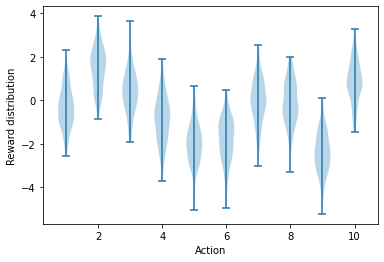

In [5]:
figure_2_1()

In [6]:
def figure_2_3(runs=2000, time=1000):
    # - 긍정적 초깃값을 사용하기 위해서는 시간 간격의 크기를 설정해야 한다.
    #   기하급수적 가중 평균을 사용함으로써 초깃값 편차를 활용한다.
    # - 반면, 시간 간격의 크기를 설정하지 않을 경우, 긍정적 초깃값을 이용할 수 없다.
    #   이때는 표본 평균 방법을 사용하게 되어 초깃값 편차가 사라지기 때문이다.
    epsilons = [0, 0.1]
    initials = [5, 0]
    time_steps = [0.1, None]
    bandits = [Bandit(epsilon=eps, initial=init, time_step=step) for eps, init, step in zip(epsilons, initials, time_steps)]
    mean_rewards, mean_best_action_count = simulate(runs, time, bandits)

    plt.figure(figsize=(10, 20))
    plt.subplot(2, 1, 1)
    for eps, init, step, reward in zip(epsilons, initials, time_steps, mean_rewards):
        plt.plot(reward, label="epsilon = {:.02f}, initial value = {}, time step = {}".format(eps, init, step))
    plt.title("Stationary Problem")
    plt.xlabel("steps")
    plt.ylabel("average reward")
    plt.legend()

    plt.subplot(2, 1, 2)
    for eps, init, step, counts in zip(epsilons, initials, time_steps, mean_best_action_count):
        plt.plot(counts, label="epsilon = {:.02f}, initial value = {}, time step = {}".format(eps, init, step))
    plt.title("Stationary Problem")
    plt.xlabel("steps")
    plt.ylabel("% optimal action")
    plt.ylim((0, 1))
    plt.legend()

    plt.show()

epsilon = 0.00, nonstationary = False, time step = 0.1 : 100%|██████████| 2000/2000 [02:44<00:00, 12.12it/s]
epsilon = 0.10, nonstationary = False, time step = None : 100%|██████████| 2000/2000 [02:26<00:00, 13.62it/s]


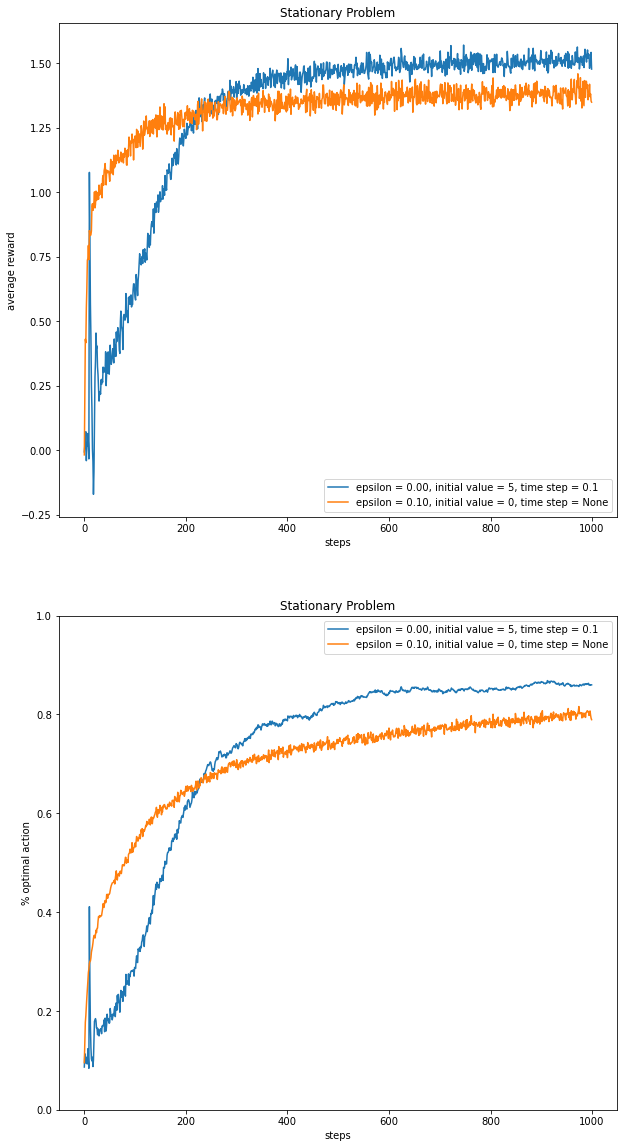

In [7]:
figure_2_3()